# Desafío #4: Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import numpy as np
import pandas as pd

from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, SpatialDropout1D, GRU
from keras.preprocessing.text import Tokenizer              # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence  # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences                       # se utilizará para padding

In [2]:
# largo de la secuencia, incluye seq input + word output
train_len = 4

### Datos
Utilizaremos como dataset el texto de los últimos 16 discursos del presidente.

In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
# el dataset se modificó de forma que donde había un "." ahora aparece tres veces la palabra "NULL". Esto se realiza para intentar separar las oraciones cuando se agrupen los tokens de a 4 (solo funciona si train_len es igual a 4).
df = pd.read_csv('_discursos.txt', sep='/n', header=None)
df.head()

<ipython-input-3-0c1638967f5e>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('_discursos.txt', sep='/n', header=None)


,0
0,Para nosotros la Argentina no es Puerto Madero...
1,Muchas veces se piensa que la obra pública se ...
2,Tenemos más de 6700 obras públicas iniciadas y...
3,Las empezamos y las terminamos y nunca a nadie...
4,"No, porque la verdad lo que hacemos es trabaja..."


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 373


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [5]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Para nosotros la Argentina no es Puerto Madero...
1     Muchas veces se piensa que la obra pública se ...
2     Tenemos más de 6700 obras públicas iniciadas y...
3     Las empezamos y las terminamos y nunca a nadie...
4     No, porque la verdad lo que hacemos es trabaja...
5     Así que yo lo que les pido es, que con la fuer...
6     Aun recuerdo perfectamente aquel 11 de septiem...
7     Eran los días de Salvador Allende, y todos mir...
8     Y aquel, 11 de septiembre, todo se volvió oscu...
9     Más de 40000 personas fueron perseguidas, tort...
10    El régimen totalitario, autoritario de Pinoche...
11    Aún, hoy, en Chile, perduran voces que defiend...
12    Son voces que – definitivamente no valoran la ...
13    Me hubiera gustado mucho poder estar acompañán...
14    Fue por eso, que la semana pasada, le quité la...
15    Ahora estamos en otro tiempo, donde afloran lo...
Name: 0, dtype: object

In [6]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Para nosotros la Argentina no es Puerto Madero, la Argentina es toda y todos necesitan vivir mejor NULL NULL NULL Muchas veces se piensa que la obra pública se usa políticamente para avalar a una intendenta propia; en la Argentina todos los municipios han recibido obra pública de la Nación NULL NULL NULL Tenemos más de 6700 obras públicas iniciadas y 4000 ya terminada NULL NULL NULL Las empezamos y las terminamos y nunca a nadie le preguntamos de qué ideología era el Intendente, ni el Gobernador NULL NULL NULL No, porque la verdad lo que hacemos es trabajar para la gente NULL NULL NULL Así que yo lo que les pido es, que con la fuerza con que hicieron esta autopista maravillosa, enorme, realmente un encanto verla así, con la misma fuerza sigan trabajando que vamos a ir mejorando NULL NULL NULL Aun recuerdo perfectamente aquel 11 de septiembre de 1973, porque la Argentina se conmovió como se conmovió todo el mundo, pero tal vez allí, donde éramos todos parte de una generación que emergí

In [7]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['para',
 'nosotros',
 'la',
 'argentina',
 'no',
 'es',
 'puerto',
 'madero',
 'la',
 'argentina',
 'es',
 'toda',
 'y',
 'todos',
 'necesitan',
 'vivir',
 'mejor',
 'null',
 'null',
 'null']

In [8]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 15761


In [9]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [10]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['para', 'nosotros', 'la', 'argentina'],
 ['nosotros', 'la', 'argentina', 'no'],
 ['la', 'argentina', 'no', 'es'],
 ['argentina', 'no', 'es', 'puerto'],
 ['no', 'es', 'puerto', 'madero'],
 ['es', 'puerto', 'madero', 'la'],
 ['puerto', 'madero', 'la', 'argentina'],
 ['madero', 'la', 'argentina', 'es'],
 ['la', 'argentina', 'es', 'toda'],
 ['argentina', 'es', 'toda', 'y'],
 ['es', 'toda', 'y', 'todos'],
 ['toda', 'y', 'todos', 'necesitan'],
 ['y', 'todos', 'necesitan', 'vivir'],
 ['todos', 'necesitan', 'vivir', 'mejor'],
 ['necesitan', 'vivir', 'mejor', 'null'],
 ['vivir', 'mejor', 'null', 'null'],
 ['mejor', 'null', 'null', 'null'],
 ['null', 'null', 'null', 'muchas'],
 ['null', 'null', 'muchas', 'veces'],
 ['null', 'muchas', 'veces', 'se']]

In [11]:
# Proceso de tokenización
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [12]:
# Ahora reemplazo todos los elementos con valor 1 por 0 en cada vector
#sequences = [[0 if elemento == 1 else elemento for elemento in vector] for vector in sequences]

# Damos un vistazo
sequences[:20]


[[13, 33, 4, 23],
 [33, 4, 23, 10],
 [4, 23, 10, 12],
 [23, 10, 12, 196],
 [10, 12, 196, 197],
 [12, 196, 197, 4],
 [196, 197, 4, 23],
 [197, 4, 23, 12],
 [4, 23, 12, 198],
 [23, 12, 198, 5],
 [12, 198, 5, 31],
 [198, 5, 31, 259],
 [5, 31, 259, 298],
 [31, 259, 298, 135],
 [259, 298, 135, 1],
 [298, 135, 1, 1],
 [135, 1, 1, 1],
 [1, 1, 1, 74],
 [1, 1, 74, 117],
 [1, 74, 117, 16]]

In [13]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 15757


### 3 - Input y target

In [14]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(15757, 3)
(15757,)


In [15]:
# Palabras del vocabulario
tok.index_word

{1: 'null',
 2: 'que',
 3: 'de',
 4: 'la',
 5: 'y',
 6: 'a',
 7: 'en',
 8: 'el',
 9: 'los',
 10: 'no',
 11: 'un',
 12: 'es',
 13: 'para',
 14: 'lo',
 15: 'por',
 16: 'se',
 17: 'una',
 18: 'porque',
 19: 'con',
 20: 'las',
 21: 'del',
 22: 'más',
 23: 'argentina',
 24: 'nos',
 25: 'eso',
 26: 'yo',
 27: 'hay',
 28: 'agua',
 29: 'como',
 30: 'todo',
 31: 'todos',
 32: 'pero',
 33: 'nosotros',
 34: 'les',
 35: '–',
 36: 'me',
 37: 'al',
 38: 'ese',
 39: 'su',
 40: 'esa',
 41: 'estamos',
 42: 'este',
 43: 'pública',
 44: 'mundo',
 45: 'son',
 46: 'cuando',
 47: 'hacer',
 48: 'también',
 49: 'está',
 50: 'universidad',
 51: 'qué',
 52: 'donde',
 53: 'era',
 54: 'si',
 55: 'años',
 56: 'ustedes',
 57: 'todas',
 58: 'esto',
 59: 'mil',
 60: 'están',
 61: 'salud',
 62: 'estado',
 63: 'ser',
 64: 'argentinos',
 65: 'país',
 66: 'hoy',
 67: 'fue',
 68: 'sus',
 69: 'mucho',
 70: 'tiene',
 71: 'buenos',
 72: 'aires',
 73: 'tenemos',
 74: 'muchas',
 75: 'obras',
 76: 'o',
 77: 'nacional',
 78: 'ob

In [16]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2858

In [17]:
# valor minimo:
print(min(y_data_int))

1


In [18]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(15757, 2858)

### 4 - Entrenar el modelo

In [19]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [20]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

2858

Se ha probado varias arquitecturas diferentes variando output_dim, cantidad de neuronas entre las capas, incluyendo BRNN y modificando la cantidad de epochs. También se probó la utilización de GRU.

In [21]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              14295     
                                                                 
 bidirectional (Bidirection  (None, 3, 256)            103680    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 3, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 2858)              3

In [22]:
hist = model.fit(x_data, y_data, epochs=120, validation_split=0.2)

Epoch 1/120
394/394 [==============================] - 23s 26ms/step - loss: 6.2616 - accuracy: 0.0763 - val_loss: 6.2763 - val_accuracy: 0.0682
Epoch 2/120
394/394 [==============================] - 5s 13ms/step - loss: 5.6455 - accuracy: 0.1020 - val_loss: 6.3478 - val_accuracy: 0.0920
Epoch 3/120
394/394 [==============================] - 4s 11ms/step - loss: 5.3595 - accuracy: 0.1170 - val_loss: 6.5833 - val_accuracy: 0.1053
Epoch 4/120
394/394 [==============================] - 5s 14ms/step - loss: 5.1550 - accuracy: 0.1277 - val_loss: 6.5891 - val_accuracy: 0.1152
Epoch 5/120
394/394 [==============================] - 5s 12ms/step - loss: 4.9934 - accuracy: 0.1343 - val_loss: 6.9625 - val_accuracy: 0.1174
Epoch 6/120
394/394 [==============================] - 5s 12ms/step - loss: 4.8582 - accuracy: 0.1407 - val_loss: 7.0902 - val_accuracy: 0.1155
Epoch 7/120
394/394 [==============================] - 5s 12ms/step - loss: 4.7263 - accuracy: 0.1471 - val_loss: 7.2553 - val_accuracy

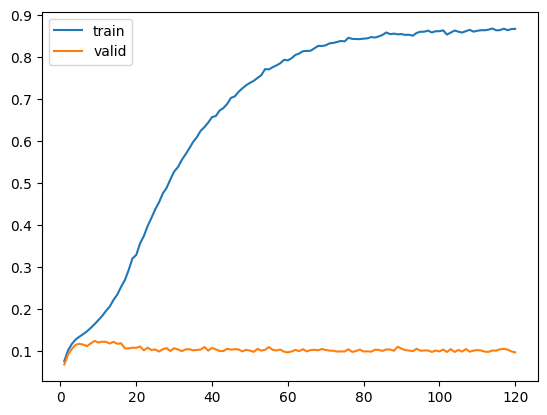

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [24]:
#import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

#iface = gr.Interface(fn=model_response, inputs=["textbox"], outputs="text", layout="vertical")

#iface.launch(debug=True)

In [25]:
model_response("Argentina es un")

1/1 [==============================] - 1s 1s/step


'Argentina es un solo'

In [26]:
model_response("Argentina no es")

1/1 [==============================] - 0s 20ms/step


'Argentina no es acueducto'

In [37]:
model_response("los jovenes son")

1/1 [==============================] - 0s 28ms/step


'los jovenes son adelante'

### 6 - Generación de secuencias nuevas

In [38]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [40]:
input_text='la argentina es'

generate_seq(model, tok, input_text, max_length=5, n_words=6)

1/1 [==============================] - 0s 39ms/step


'la argentina es enorme ¿sabes los pampa muy decía'

### 7 - Beam search y muestreo aleatorio

In [41]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [42]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [43]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=3,input="este presidente es")

1/1 [==============================] - 0s 18ms/step


In [44]:
# veamos las salidas
decode(salidas[0])

['este presidente es haciendo… les mi']

### 8 - Conclusiones

Este modelo entrenado mostró un rendimiento deficiente, ya que sufrió de un marcado sobreajuste. Aunque se ajustó bien a los datos de entrenamiento, falló en la capacidad de generalización. Se realizaron varios intentos con diferentes arquitecturas, pero no se logró mejorar la precisión en la validación.

Mi conclusión es que para mejorar el rendimiento, se requiere un conjunto de datos significativamente más extenso. El conjunto de datos utilizado en este proceso de entrenamiento resultó ser insuficiente para obtener resultados satisfactorios.